# Causal Inference in Internal space using natural parameters and assuming Angle space responses

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import vonmises
from custom_causal_inference import CustomCausalInference
import utils
import plots
import forward_models_causal_inference

## Setup

In [ ]:
num_sim = 1000
D = 250  # grid dimension 
angle_gam_data_path = 'D:/AK_Q1_2024/Gatsby/data/base_bayesian_contour_1_circular_gam/base_bayesian_contour_1_circular_gam.pkl'
unif_fn_data_path='D:/AK_Q1_2024/Gatsby/uniform_model_base_inv_kappa_free.pkl'
p_commons = [0, .2, .5, .7, 1]

# Initialise mean parameters causal inference model for comparison
causal_inference_estimator = forward_models_causal_inference.CausalEstimator(
    model=CustomCausalInference(decision_rule='mean'),
    angle_gam_data_path=angle_gam_data_path,
    unif_fn_data_path=unif_fn_data_path)
unif_map = causal_inference_estimator.unif_map

## Select the means of cues used for causal inference and the "ground-truth" corresponding responses 

Get the s_n, t, r_n(s_n, t) values of interest

In [3]:
s_n, t, r_n = utils.get_s_n_and_t(causal_inference_estimator.grid, 
                                   causal_inference_estimator.gam_data)
s_n.shape, t.shape, r_n.shape

((250, 250), (250, 250), (250, 250))

Further filter the values of s_n, t considered (and r_n implicitly) for faster simulations

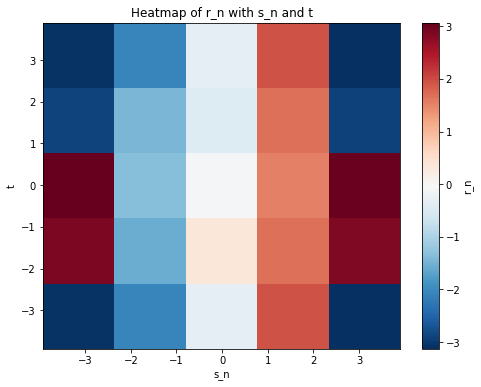

<Figure size 432x288 with 0 Axes>

In [4]:
num_means = 4
step=len(s_n)//num_means
indices = np.arange(0, s_n.shape[0], step=step)
mu_x_dim = len(indices)
s_n = s_n[indices][:, indices]
t = t[indices][:, indices]
r_n = r_n[indices][:, indices]
plots.heatmap_f_s_n_t(f_s_n_t=r_n, s_n=s_n, t=t, f_name='r_n')

In [5]:
s_n.shape, t.shape

((5, 5), (5, 5))

## Causal inference

### Convert means to internal space

In [5]:
s_n, t, r_n = s_n.flatten(), t.flatten(), r_n.flatten()
us_n = unif_map.angle_space_to_unif_space(s_n)
ut = unif_map.angle_space_to_unif_space(t)
print(f'Performing causal inference for ut, u_s_n of shape {ut.shape, us_n.shape}')

Performing causal inference for ut, u_s_n of shape ((25,), (25,))


### Create the grid and the prior over natural parameters

In [6]:
def get_nat_params(mus, kappas):
    """
    Computes the natural parameters eta = kappa * [cos(mu), sin(mu)] for all combinations of mu and kappa.

    Parameters:
    - mus: Array of mu values, shape (M,)
    - kappas: Array of kappa values, shape (K,)

    Returns:
    - nat_params: Natural parameters, shape (M, K, 2)
    """
    # Create meshgrid of mu and kappa
    mu_grid, kappa_grid = np.meshgrid(mus, kappas, indexing='ij')  # shape (M, K)

    # Compute cos(mu) and sin(mu)
    cos_mu = np.cos(mu_grid)  # shape (M, K)
    sin_mu = np.sin(mu_grid)  # shape (M, K)
    # Compute eta components
    eta_x = kappa_grid * cos_mu  # shape (M, K)
    eta_y = kappa_grid * sin_mu  # shape (M, K)
    # Stack eta_x and eta_y into nat_params
    nat_params = np.stack((eta_x, eta_y), axis=-1)  # shape (M, K, 2)

    return nat_params

def get_uniform_eta_prior(etas):
    """
    Computes a uniform prior over eta.

    Parameters:
    - etas: Natural parameters, shape (E, 2)

    Returns:
    - prior: Uniform prior, shape (E,)
    """
    E = etas.shape[0]
    return np.ones(E) / E

def get_fixed_prior(etas, kappa_idx):
    """
    Generates a probability distribution over eta vectors, that is uniform across means and nonzero only for the kappa_idx'th kappa.

    This function creates a prior `p` over the flattened eta vectors, where only the eta vectors at a specified
    `kappa_idx` along the kappa dimension have non-zero probabilities. The non-zero probabilities are uniformly
    distributed across the mu dimension at the specified kappa index.

    Parameters:
    - etas: numpy.ndarray
        A 3-dimensional array of natural parameters eta, with shape `(num_mu, num_kappa, D)`, where:
        - `num_mu` is the number of mu values,
        - `num_kappa` is the number of kappa values,
        - `D` is the dimensionality of the eta vectors (typically `D=2`).
    - kappa_idx: int
        The index along the kappa dimension to which the prior is fixed.

    Returns:
    - p: numpy.ndarray
        A 1-dimensional array of prior probabilities over eta vectors, flattened to shape `(num_mu * num_kappa,)`.
        The prior probabilities are zero except for the eta vectors at the specified `kappa_idx`, which are set
        to `1 / num_mu`.
    """
    assert (etas.ndim == 3)
    p = np.zeros(etas.shape[:-1])
    p[:, kappa_idx] = 1 / etas.shape[0]
    return p.reshape(-1,)

# Generate kappas and mus
kappas = np.logspace(start=0, stop=np.log10(500), num=100, base=10)
mus = np.linspace(-np.pi, np.pi, num=250)

# Compute natural parameters and prior
etas = get_nat_params(mus, kappas)
print(etas.shape)
kappa_idx1, kappa_idx2 = 30, 60
prior_eta_kappa_idx1 = get_fixed_prior(etas, kappa_idx=kappa_idx1)
prior_eta_kappa_idx2 = get_fixed_prior(etas, kappa_idx=kappa_idx2)
etas = etas.reshape((-1, 2))
unif_prior_eta = get_uniform_eta_prior(etas)
mus.shape, kappas.shape, etas.shape, unif_prior_eta.shape, prior_eta_kappa_idx1.shape

(250, 100, 2)


((250,), (100,), (25000, 2), (25000,), (25000,))

In [7]:
sum(prior_eta_kappa_idx1), sum(prior_eta_kappa_idx2), sum(unif_prior_eta)

(1.0000000000000007, 1.0000000000000007, 1.000000000000437)

### Compute the posterior over $\eta$

Note that the posteriors are determined proportionally, hence we need to normalise by performing the integration over $\boldsymbol{\eta}$. For now*, in the code below, we approximate normalisation by dividing by the sum of the product of probabilities across the discrete set of $\boldsymbol{\eta}$ parameters used.

1. $p(\boldsymbol{\eta} \vert \boldsymbol{s_1}, \boldsymbol{s_2}, C=1) \propto p(\boldsymbol{s_1} \mid \boldsymbol{\eta})p(\boldsymbol{s_2} \mid \boldsymbol{\eta})p(\boldsymbol{\eta})$

2. $p(\boldsymbol{\eta_i} \vert \boldsymbol{s_i}, C=2) \propto p(\boldsymbol{s_i} \mid \boldsymbol{\eta_i})p(\boldsymbol{\eta_i})$

In [8]:
def get_p_eta_common_cause(p_eta, etas, s_1, s_2):
    """
    Computes the normalized posterior probabilities p(eta | s_1, s_2)
    for the common cause scenario when s_1 and s_2 are 1D arrays.

    Parameters:
    - p_eta: Prior probabilities over eta, shape (e,)
    - etas: Natural parameters, shape (e, 2)
    - s_1: Observations from the first cue, shape (n,)
    - s_2: Observations from the second cue, shape (n,)

    Returns:
    - p_eta_given_s1_s2_normalized: Normalized posterior probabilities, shape (n, e)
    """
    # Compute mu and kappa from etas
    mu = np.arctan2(etas[:, 1], etas[:, 0])       # shape (e,)
    kappa = np.linalg.norm(etas, axis=1)          # shape (e,)

    # Reshape s_1 and s_2 for broadcasting
    s_1 = s_1[:, np.newaxis]                      # shape (n, 1)
    s_2 = s_2[:, np.newaxis]                      # shape (n, 1)

    # Reshape mu and kappa for broadcasting
    mu = mu[np.newaxis, :]                        # shape (1, e)
    kappa = kappa[np.newaxis, :]                  # shape (1, e)

    # Compute the Von Mises PDF for s_1 and s_2
    vm_pdf_s1 = vonmises.pdf(s_1, kappa, loc=mu)  # shape (n, e)
    vm_pdf_s2 = vonmises.pdf(s_2, kappa, loc=mu)  # shape (n, e)

    # Reshape p_eta for broadcasting
    p_eta = p_eta[np.newaxis, :]                  # shape (1, e)

    # Compute the unnormalized posterior probabilities
    unnormalized_posterior = vm_pdf_s1 * vm_pdf_s2 * p_eta  # shape (n, e)

    # Compute the sum over eta to normalize
    sum_over_eta = np.sum(unnormalized_posterior, axis=1, keepdims=True)  # shape (n, 1)

    # Avoid division by zero
    sum_over_eta[sum_over_eta == 0] = 1e-10

    # Normalize the posterior probabilities
    p_eta_given_s1_s2_normalized = unnormalized_posterior / sum_over_eta  # shape (n, e)

    return p_eta_given_s1_s2_normalized

def get_p_eta_separate_cause(p_eta, etas, s):
    """
    Computes the normalized posterior probabilities p(eta | s)
    for the separate cause scenario when s is a 1D array.

    Parameters:
    - p_eta: Prior probabilities over eta, shape (e,)
    - etas: Natural parameters, shape (e, 2)
    - s: Observations, shape (n,)

    Returns:
    - p_eta_given_s_normalized: Normalized posterior probabilities, shape (n, e)
    """
    # Compute mu and kappa from etas
    mu = np.arctan2(etas[:, 1], etas[:, 0])       # shape (e,)
    kappa = np.linalg.norm(etas, axis=1)          # shape (e,)

    # Reshape s for broadcasting
    s = s[:, np.newaxis]                          # shape (n, 1)

    # Reshape mu and kappa for broadcasting
    mu = mu[np.newaxis, :]                        # shape (1, e)
    kappa = kappa[np.newaxis, :]                  # shape (1, e)

    # Compute the Von Mises PDF for s
    vm_pdf_s = vonmises.pdf(s, kappa, loc=mu)     # shape (n, e)

    # Reshape p_eta for broadcasting
    p_eta = p_eta[np.newaxis, :]                  # shape (1, e)

    # Compute the unnormalized posterior probabilities
    unnormalized_posterior = vm_pdf_s * p_eta     # shape (n, e)

    # Compute the sum over eta to normalize
    sum_over_eta = np.sum(unnormalized_posterior, axis=1, keepdims=True)  # shape (n, 1)

    # Avoid division by zero
    sum_over_eta[sum_over_eta == 0] = 1e-10

    # Normalize the posterior probabilities
    p_eta_given_s_normalized = unnormalized_posterior / sum_over_eta      # shape (n, e)

    return p_eta_given_s_normalized

def get_expected_value(p_eta, eta):
    """
    Computes the expected value of eta under the probability distribution p_eta.

    Parameters:
    - p_eta: Array of probabilities over eta, shape (E,)
      Represents the probability distribution over eta vectors.
    - eta: Array of eta vectors, shape (E, D)
      Each row eta[i, :] is an eta vector of dimensionality D.

    Returns:
    - expected_value: The expected value of eta under p_eta, shape (D,)
      Calculated as the weighted (by p_eta) sum of eta vectors.
    """
    return (p_eta.reshape(-1, 1)*eta).sum(axis=0)

In [9]:
eta_priors = {'unif_prior': unif_prior_eta,
              'kappa_idx1': prior_eta_kappa_idx1,
              'kappa_idx2': prior_eta_kappa_idx2}
eta_posteriors = {}

In [10]:
for eta_prior_type in eta_priors:
    eta_posteriors[eta_prior_type] = {}
    eta_prior = eta_priors[eta_prior_type]
    p_eta_common_cause = get_p_eta_common_cause(p_eta=eta_prior, etas=etas,
                                            s_1=ut, s_2=us_n).reshape((mu_x_dim, mu_x_dim, -1))
    p_eta_separate_cause_t = get_p_eta_separate_cause(p_eta=eta_prior, etas=etas,
                                                s=ut).reshape((mu_x_dim, mu_x_dim, -1))
    p_eta_separate_cause_s = get_p_eta_separate_cause(p_eta=eta_prior, etas=etas,
                                                s=us_n).reshape((mu_x_dim, mu_x_dim, -1))
    eta_posteriors[eta_prior_type]['p_eta_common_cause'] = p_eta_common_cause
    eta_posteriors[eta_prior_type]['p_eta_separate_cause_t'] = p_eta_separate_cause_t
    eta_posteriors[eta_prior_type]['p_eta_separate_cause_s'] = p_eta_separate_cause_s

In [23]:
eta_angles = {}
for eta_prior_type in eta_priors:
    eta_angles[eta_prior_type] = {'common_cause': np.zeros((mu_x_dim, mu_x_dim)),
                                's_n': np.zeros((mu_x_dim, mu_x_dim)),
                                't': np.zeros((mu_x_dim, mu_x_dim))}
    p_eta_separate_cause_s = eta_posteriors[eta_prior_type]['p_eta_separate_cause_s']
    p_eta_common_cause = eta_posteriors[eta_prior_type]['p_eta_common_cause']
    p_eta_separate_cause_t = eta_posteriors[eta_prior_type]['p_eta_separate_cause_t']
    for i1 in range(mu_x_dim):
        for i2 in range(mu_x_dim):
            eta2_hat = get_expected_value(p_eta_separate_cause_s[i1,i2], etas)
            eta_angles[eta_prior_type]['s_n'][i1, i2] = np.arctan2(eta2_hat[1], eta2_hat[0])
            print(f'mean of p(eta|s_n, C=2) for {eta_prior_type}: ||eta|| = {np.linalg.norm(eta2_hat)}, eta_angle={eta_angles[eta_prior_type]["s_n"][i1, i2]}, '
                  f'u_t = {ut.reshape((5, 5))[i1, i2]}, u_s_n={us_n.reshape((5, 5))[i1, i2]}')
            eta1_hat = get_expected_value(p_eta_separate_cause_t[i1,i2], etas)
            eta_angles[eta_prior_type]['t'][i1, i2] = np.arctan2(eta1_hat[1], eta1_hat[0])
            eta_hat = get_expected_value(p_eta_common_cause[i1,i2], etas)
            eta_angles[eta_prior_type]['common_cause'][i1, i2] = np.arctan2(eta_hat[1], eta_hat[0])
            # print(f'mean for (p(eta|t, C=2) for {eta_prior_type}: ||eta|| = {np.linalg.norm(eta1_hat)}, eta_angle={eta_angles[eta_prior_type]["t"][i1, i2]}, '
            #       f'u_t = {ut.reshape((5, 5))[i1, i2]}, u_s_n={us_n.reshape((5, 5))[i1, i2]}')

mean of p(eta|s_n, C=2) for unif_prior: ||eta|| = 87.81438264399918, eta_angle=-3.1335471933000085, u_t = -3.132328046463897, u_s_n=-3.132328046463897
mean of p(eta|s_n, C=2) for unif_prior: ||eta|| = 81.46326285805036, eta_angle=-1.5826015362804586, u_t = -3.132328046463897, u_s_n=-1.5825920017703348
mean of p(eta|s_n, C=2) for unif_prior: ||eta|| = 81.49076712126524, eta_angle=0.05616163826253321, u_t = -3.132328046463897, u_s_n=0.05616155368553866
mean of p(eta|s_n, C=2) for unif_prior: ||eta|| = 81.45679289563039, eta_angle=1.6757937661474858, u_t = -3.132328046463897, u_s_n=1.6757819928537376
mean of p(eta|s_n, C=2) for unif_prior: ||eta|| = 86.14823888608029, eta_angle=3.10622066044623, u_t = -3.132328046463897, u_s_n=3.1019386538799694
mean of p(eta|s_n, C=2) for unif_prior: ||eta|| = 87.81438264399918, eta_angle=-3.1335471933000085, u_t = -1.5825920017703348, u_s_n=-3.132328046463897
mean of p(eta|s_n, C=2) for unif_prior: ||eta|| = 81.46326285805036, eta_angle=-1.5826015362804

### Compare with causal inference in the mean parameters model

#### Find the optimal fusion and seggregation estimates

In [18]:
# For fair comparison to the natural parameters model where for C=1 we use \eta_1=\eta_2=\eta, kappa2 will be set to kappa1
kappa1 = np.array([kappas[kappa_idx1], kappas[kappa_idx2]])
kappa2 = np.array([kappas[kappa_idx1], kappas[kappa_idx2]])

In [ ]:
kappa1_reshaped = forward_models_causal_inference.reshape_kappa_for_causal_inference(kappa1, num_mus=ut.shape[0])
kappa2_reshaped = forward_models_causal_inference.reshape_kappa_for_causal_inference(kappa2, num_mus=us_n.shape[0])

fusion_estimates = causal_inference_estimator.model.fusion_estimate(x_v=ut.reshape(-1, 1), x_a=us_n.reshape(-1, 1),
                                                 sigma_v=kappa1_reshaped,
                                                 sigma_a=kappa2_reshaped,
                                                 mu_p=None, sigma_p=None)
seggregation_estimates_1 = causal_inference_estimator.model.segregation_estimate(x=ut.reshape(-1, 1), sigma=kappa1_reshaped, 
                                                                                 mu_p=None, sigma_p=None)
seggregation_estimates_2 = causal_inference_estimator.model.segregation_estimate(x=us_n.reshape(-1, 1), sigma=kappa2_reshaped, 
                                                                                 mu_p=None, sigma_p=None)

In [20]:
fusion_estimates.shape, seggregation_estimates_1.shape, seggregation_estimates_2.shape

((25, 2), (25, 2), (25, 2))

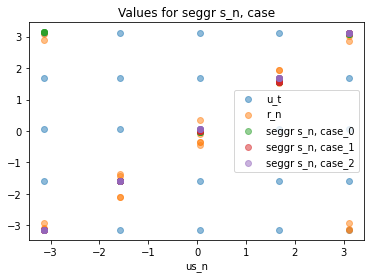

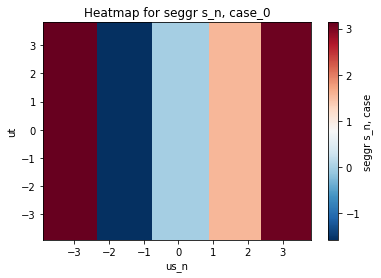

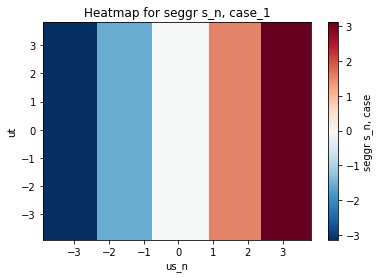

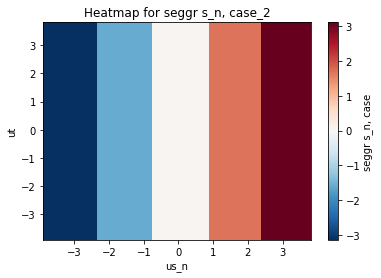

<Figure size 432x288 with 0 Axes>

In [45]:
estimtes_s_n_kappa_idx1 = np.concatenate([seggregation_estimates_2[:, 0].reshape((-1, 1)), 
                                          unif_map.unif_space_to_angle_space(eta_angles['kappa_idx1']['s_n']).reshape((-1, 1)),
                                          eta_angles['kappa_idx1']['s_n'].reshape((-1, 1))],
                                          axis=-1)
# Case_0 --> seggregation_estimate from mean params model
# Case_1 --> U^{-1}(\widehat{\hat{eta_2}}), i.e. the angle corresponding to the mean of the posterior over eta_2 after converting to angle space
# Case_2 --> \widehat{\hat{eta_2}, i.e. the angle (in uniformised space) corresponding to the mean of the posterior over eta_2

plots.plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=mu_x_dim, 
                    estimate=estimtes_s_n_kappa_idx1,
                    est_label=f'seggr s_n, case', 
                    plot_heatmap=True)

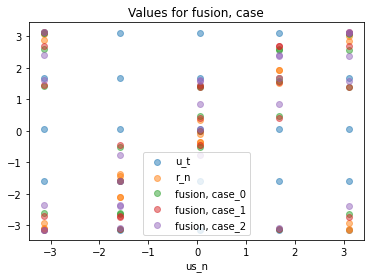

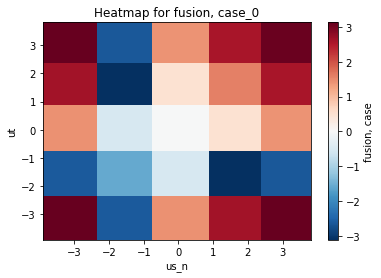

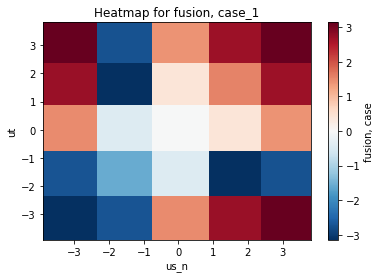

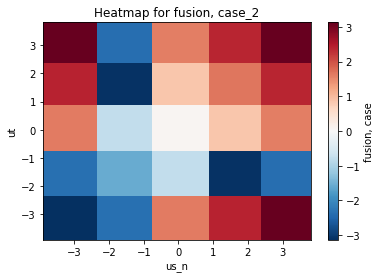

<Figure size 432x288 with 0 Axes>

In [53]:
estimtes_common_kappa_idx1 = np.concatenate([fusion_estimates[:, 0].reshape((-1, 1)), 
                                          unif_map.unif_space_to_angle_space(eta_angles['kappa_idx1']['common_cause']).reshape((-1, 1)),
                                          eta_angles['kappa_idx1']['common_cause'].reshape((-1, 1))],
                                          axis=-1)
# Case_0 --> fusion_estimate from mean params model
# Case_1 --> U^{-1}(\widehat{\hat{eta}}), i.e. the angle corresponding to the mean of the posterior over eta after converting to angle space
# Case_2 --> \widehat{\hat{eta}, i.e. the angle (in uniformised space) corresponding to the mean of the posterior over eta
plots.plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=mu_x_dim, 
                    estimate=estimtes_common_kappa_idx1,
                    est_label=f'fusion, case', 
                    plot_heatmap=True)

In [43]:
seggregation_estimates_2[:, 0], unif_map.unif_space_to_angle_space(eta_angles['kappa_idx1']['s_n']), eta_angles['kappa_idx1']['s_n']

(array([ 3.13667217, -1.58047391, -0.02162123,  1.55563517,  3.09108528,
         3.13667217, -1.58047391, -0.02162123,  1.55563517,  3.09108528,
         3.13667217, -1.58047391, -0.02162123,  1.55563517,  3.09108528,
         3.13667217, -1.58047391, -0.02162123,  1.55563517,  3.09108528,
         3.13667217, -1.58047391, -0.02162123,  1.55563517,  3.09108528]),
 array([[-3.14159274, -1.57717406, -0.01261684,  1.55200917,  3.11720372],
        [-3.14159274, -1.57717406, -0.01261684,  1.55200917,  3.11720372],
        [-3.14159274, -1.57717406, -0.01261684,  1.55200917,  3.11720372],
        [-3.14159274, -1.57717406, -0.01261684,  1.55200917,  3.11720372],
        [-3.14159274, -1.57717406, -0.01261684,  1.55200917,  3.11720372]]),
 array([[-3.13257564, -1.58263341,  0.05616156,  1.6758579 ,  3.10299312],
        [-3.13257564, -1.58263341,  0.05616156,  1.6758579 ,  3.10299312],
        [-3.13257564, -1.58263341,  0.05616156,  1.6758579 ,  3.10299312],
        [-3.13257564, -1.582633

In [52]:
fusion_estimates[:, 0], unif_map.unif_space_to_angle_space(eta_angles['kappa_idx1']['common_cause']), eta_angles['kappa_idx1']['common_cause']

(array([ 3.12903618, -2.6165549 ,  1.42747434,  2.61805563,  3.10562976,
        -2.6165549 , -1.59452645, -0.51636788, -3.11162526, -2.63249776,
         1.42747434, -0.51636788, -0.01502007,  0.47394668,  1.40786006,
         2.61805563, -3.11162526,  0.47394668,  1.58734646,  2.58043867,
         3.10562976, -2.63249776,  1.40786006,  2.58043867,  3.09359243]),
 array([[-3.14159274, -2.7108875 ,  1.46785324,  2.70725841,  3.13473324],
        [-2.7108875 , -1.57710489, -0.43408461, -3.11864699, -2.72975034],
        [ 1.46785324, -0.43408461, -0.01261684,  0.40470758,  1.3987563 ],
        [ 2.70725841, -3.11864699,  0.40470758,  1.5518716 ,  2.68983753],
        [ 3.13473324, -2.72975034,  1.3987563 ,  2.68983753,  3.11749857]]),
 array([[-3.13266362, -2.35892069,  1.62947429,  2.41515956,  3.12694773],
        [-2.35892069, -1.58259209, -0.76321523, -3.09595339, -2.38367901],
        [ 1.62947429, -0.76321523,  0.05616155,  0.86597178,  1.59125451],
        [ 2.41515956, -3.095953

#### Simulate full causal inference by sampling the 2 internal estimates for each pair of means (and associated concentration pairs)

In [22]:
results = {
    'responses': [], 
    'posterior_p_common': [],
    'mean_t_est': [], 
    'mean_sn_est': []
}
results['num_sim'] = 10000
results['ut'] = ut
results['us_n'] = us_n
t_samples, s_n_samples = causal_inference_estimator.get_vm_samples(num_sim=results['num_sim'], 
                                                                    mu_t=ut, mu_s_n=us_n,
                                                                    kappa1=kappa1, 
                                                                    kappa2=kappa2)

In [ ]:
for p_common in p_commons:
    responses, posterior_p_common, mean_t_est, mean_sn_est = causal_inference_estimator.forward(t_samples=t_samples,
                                                                                                s_n_samples=s_n_samples,
                                                                                                p_common=p_common,
                                                                                                kappa1=kappa1,
                                                                                                kappa2=kappa2)
    results['responses'].append(responses)
    results['posterior_p_common'].append(posterior_p_common)
    results['mean_t_est'].append(mean_t_est)
    results['mean_sn_est'].append(mean_sn_est)

### Tests to be moved once we're happy with the model

In [54]:
# Test get_nat_params

# Test inputs
mus = np.array([0, np.pi/2, np.pi])
kappas = np.array([1, 2])

# Expected outputs
expected_eta = np.array([
    [[1 * np.cos(0),       1 * np.sin(0)],
     [2 * np.cos(0),       2 * np.sin(0)]],
    [[1 * np.cos(np.pi/2), 1 * np.sin(np.pi/2)],
     [2 * np.cos(np.pi/2), 2 * np.sin(np.pi/2)]],
    [[1 * np.cos(np.pi),   1 * np.sin(np.pi)],
     [2 * np.cos(np.pi),   2 * np.sin(np.pi)]]
])

# Run the function
result = get_nat_params(mus, kappas)

# Check that the result matches the expected output
np.testing.assert_array_almost_equal(result, expected_eta)

# Check the shape
M, K = len(mus), len(kappas)
assert result.shape == (M, K, 2), f"Expected shape {(M, K, 2)}, but got {result.shape}"

print("get_nat_params passed the test.")

get_nat_params passed the test.


In [55]:
# Test get_uniform_eta_prior

# Test input
etas = np.random.rand(10, 2)

# Run the function
prior = get_uniform_eta_prior(etas)

# Expected output
expected_prior = np.ones(10) / 10

# Check that the prior matches the expected output
np.testing.assert_array_almost_equal(prior, expected_prior)

# Check that the prior sums to 1
assert np.isclose(np.sum(prior), 1.0), f"Sum of prior is {np.sum(prior)}, expected 1.0"

# Check the shape
assert prior.shape == (10,), f"Expected shape (10,), but got {prior.shape}"

print("get_uniform_eta_prior passed the test.")

get_uniform_eta_prior passed the test.


In [56]:
# Test get_fixed_prior

# Test inputs
num_mu, num_kappa, D = 5, 3, 2
etas = np.random.rand(num_mu, num_kappa, D)
kappa_idx = 1  # Valid index

# Run the function
prior = get_fixed_prior(etas, kappa_idx)

# Expected output
expected_prior = np.zeros(num_mu * num_kappa)
for i in range(num_mu):
    idx = i * num_kappa + kappa_idx
    expected_prior[idx] = 1 / num_mu

# Check that the prior matches the expected output
np.testing.assert_array_almost_equal(prior, expected_prior)

# Check that the prior sums to 1
assert np.isclose(np.sum(prior), 1.0), f"Sum of prior is {np.sum(prior)}, expected 1.0"

# Check the shape
assert prior.shape == (num_mu * num_kappa,), f"Expected shape {(num_mu * num_kappa,)}, but got {prior.shape}"

print("get_fixed_prior passed the test with valid kappa_idx.")

# Test invalid kappa_idx (out of bounds)
try:
    invalid_kappa_idx = num_kappa  # Out of bounds
    prior_invalid = get_fixed_prior(etas, invalid_kappa_idx)
    print("Error: get_fixed_prior did not raise an error with invalid kappa_idx.")
except IndexError as e:
    print("get_fixed_prior correctly raised an IndexError with invalid kappa_idx.")

# Test assertion error for wrong dimensions
try:
    invalid_etas = etas.reshape(-1, D)  # Not 3D
    prior_invalid = get_fixed_prior(invalid_etas, kappa_idx)
    print("Error: get_fixed_prior did not raise an error with invalid etas dimensions.")
except AssertionError as e:
    print("get_fixed_prior correctly raised an AssertionError with invalid etas dimensions.")

get_fixed_prior passed the test with valid kappa_idx.
get_fixed_prior correctly raised an IndexError with invalid kappa_idx.
get_fixed_prior correctly raised an AssertionError with invalid etas dimensions.


In [57]:
# Test get_p_eta_common_cause

# Test inputs
n = 3  # Number of observations
e = 4  # Number of eta vectors

# Observations s_1 and s_2
s_1 = np.array([0.0, np.pi/2, np.pi])  # Shape: (n,)
s_2 = np.array([np.pi/2, np.pi, 0.0])  # Shape: (n,)

# Eta vectors
etas = np.array([
    [1.0, 0.0],
    [0.0, 1.0],
    [-1.0, 0.0],
    [0.0, -1.0]
])  # Shape: (e, 2)

# Prior probabilities
p_eta = np.ones(e) / e  # Uniform prior, shape: (e,)

# Expected shapes
expected_shape = (n, e)

# Run the function
p_eta_given_s1_s2 = get_p_eta_common_cause(p_eta, etas, s_1, s_2)

# Check the shape of the output
assert p_eta_given_s1_s2.shape == expected_shape, f"Expected shape {expected_shape}, but got {p_eta_given_s1_s2.shape}"

# Check that probabilities are normalized (sum to 1 over eta for each observation)
sums = np.sum(p_eta_given_s1_s2, axis=1)
np.testing.assert_array_almost_equal(sums, np.ones(n))

# Additional check: values are non-negative
assert np.all(p_eta_given_s1_s2 >= 0), "Probabilities contain negative values."

print("get_p_eta_common_cause passed the test.")

get_p_eta_common_cause passed the test.


In [59]:
# Test get_p_eta_separate_cause

# Test inputs
n = 3  # Number of observations
e = 4  # Number of eta vectors

# Observations s
s = np.array([0.0, np.pi/2, np.pi])  # Shape: (n,)

# Eta vectors
etas = np.array([
    [1.0, 0.0],
    [0.0, 1.0],
    [-1.0, 0.0],
    [0.0, -1.0]
])  # Shape: (e, 2)

# Prior probabilities
p_eta = np.ones(e) / e  # Uniform prior, shape: (e,)

# Expected shape
expected_shape = (n, e)

# Run the function
p_eta_given_s = get_p_eta_separate_cause(p_eta, etas, s)

# Check the shape of the output
assert p_eta_given_s.shape == expected_shape, f"Expected shape {expected_shape}, but got {p_eta_given_s.shape}"

# Check that probabilities are normalized (sum to 1 over eta for each observation)
sums = np.sum(p_eta_given_s, axis=1)
np.testing.assert_array_almost_equal(sums, np.ones(n))

# Additional check: values are non-negative
assert np.all(p_eta_given_s >= 0), "Probabilities contain negative values."

print("get_p_eta_separate_cause passed the test.")

get_p_eta_separate_cause passed the test.


In [58]:
# Test get_expected_value

# Test inputs
E = 4  # Number of eta vectors
D = 2  # Dimensionality of eta vectors

# Eta vectors
eta = np.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0],
    [7.0, 8.0]
])  # Shape: (E, D)

# Corresponding probabilities
p_eta = np.array([0.1, 0.2, 0.3, 0.4])  # Shape: (E,)

# Expected value computed manually
expected_value = np.sum(p_eta.reshape(-1, 1) * eta, axis=0)

# Run the function
result = get_expected_value(p_eta, eta)

# Check that the result matches the expected value
np.testing.assert_array_almost_equal(result, expected_value)

# Check that the output has the correct shape
assert result.shape == (D,), f"Expected shape {(D,)}, but got {result.shape}"

print("get_expected_value passed the test.")

# Additional tests for edge cases

# Test with probabilities that do not sum to 1
p_eta_unnormalized = np.array([0.5, 0.5, 0.5, 0.5])  # Sum is 2.0
p_eta_normalized = p_eta_unnormalized / np.sum(p_eta_unnormalized)
expected_value = np.sum(p_eta_normalized.reshape(-1, 1) * eta, axis=0)
result = get_expected_value(p_eta_normalized, eta)
np.testing.assert_array_almost_equal(result, expected_value)
print("get_expected_value passed the test with unnormalized probabilities.")

# Test with zero probabilities
p_eta_zero = np.array([0.0, 0.0, 1.0, 0.0])  # Only the third eta has probability 1
expected_value = eta[2]
result = get_expected_value(p_eta_zero, eta)
np.testing.assert_array_almost_equal(result, expected_value)
print("get_expected_value passed the test with zero probabilities.")

get_expected_value passed the test.
get_expected_value passed the test with unnormalized probabilities.
get_expected_value passed the test with zero probabilities.
